The goal here is to check whether the FBS scheduling leads to a shallow border at the "edges" of the WFD survey. We basically consider the coadded depth in the footprint with WFD declination limits and EBV cut, look at the depth at the edges, and consider how much area we are losing by not annealing (as the shallower edges dont make past the depth cut).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
import pandas as pd
%matplotlib inline

In [2]:
import time
import copy
import numpy as np
import healpy as hp
import os
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.maf.maps as maps

In [3]:
%matplotlib inline

In [4]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [5]:
def pix2radec(nside, pix_num):
    """
    
    Given the pixel number / sliceID, return the RA/Dec of the pointing, in degrees.
    
    """
    # Calculate RA/Dec in radians of pixel in this healpix slicer.
    # Note that ipix could be an array,
    # in which case RA/Dec values will be an array also.
    lat, ra = hp.pix2ang(nside, pix_num)
    # Move dec to +/- 90 degrees
    dec = np.pi/2.0 - lat
    return np.rad2deg(ra), np.rad2deg(dec)

def plot_mollview(bundle, title, cmin=None, cmax=None,
                  change_mask=False,
                  create_mask=False, unmasked_pixels=[], return_bundle=False):
    if create_mask or change_mask:
        test_bundle = copy.deepcopy(bundle)
        if create_mask:
            test_bundle.data[:] = 0
            test_bundle.data[unmasked_pixels] = 100
        if change_mask:
            test_bundle.mask[:] = True
            test_bundle.mask[unmasked_pixels] = False
            
        title += '\narea: %.2f deg2' % ( len(unmasked_pixels) * area_ppixel )
        plt.clf()
        hp.mollview(test_bundle, flip='astro', rot=(0,0,0),
                    min=cmin, max=cmax,
                    title=title )
        hp.graticule(dpar=20, dmer=20, verbose=False)
        plt.show()
        
        if return_bundle:
            return test_bundle
    else:
        plt.clf()
        title += '\narea: %.2f deg2' % (len(np.where(bundle.mask == False)[0]) * area_ppixel)
        hp.mollview(bundle, min=cmin, max=cmax, flip='astro', rot=(0,0,0), title=title)
        hp.graticule(dpar=20, dmer=20, verbose=False)
        plt.show()

In [6]:
def run_things(dbpath, fname, nside, min_dec=-65, max_dec=7):
    
    outdir = 'results-annealing/'
    resultsDb = db.ResultsDb(outDir=outdir)
    # ---------------------------------------------------------------------------
    #### get Y10 i-band coadded depth map for the new baseline 
    # ---------------------------------------------------------------------------
    # consider only non-DD visits
    sqlconstraint = ' note not like "DD%"'
    sqlconstraint += ' and filter=="i"'

    opsdb = db.OpsimDatabase(dbpath)
    # set up the dust map
    dustmap = maps.DustMap(nside=nside, interp=False)

    # set up the metric
    metric = metrics.ExgalM5(lsstFilter='i')

    # set up slicer
    slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                   latLonDeg=opsdb.raDecInDeg, nside=nside, useCache=False)
    # setup the bundle
    depth_bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint,
                                              mapsList=[dustmap])
    # set up the group.
    grp = metricBundles.MetricBundleGroup({0: depth_bundle}, opsdb, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()
    
    # plot the map
    plot_mollview(bundle=depth_bundle.metricValues, title='i-band depth map; no cuts')
    
    # ---------------------------------------------------------------------------
    #### set up the EBV map
    # ---------------------------------------------------------------------------
    simdata = opsdb.fetchMetricData(['fieldId', 'fieldRA', 'fieldDec'],  # assume v4 outputs: fieldID in v3
                                    sqlconstraint=None)
    slicer.setupSlicer(simdata)

    result = dustmap.run(slicer.slicePoints)
    
    # plot
    cmin = -0.5; cmax = 0.5
    plt.clf()
    hp.mollview(result['ebv'], min=cmin, max=cmax, flip='astro', rot=(0,0,0), title='ebv')
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()
    # ---------------------------------------------------------------------------
    #### implement a declination cut to get WFD
    # ---------------------------------------------------------------------------
    in_survey = np.where(depth_bundle.metricValues.mask == False)[0]
    in_survey_ras, in_survey_decs = pix2radec(nside=nside, pix_num=in_survey)
    
    wfd_pixels = in_survey[ np.where( (in_survey_decs <= max_dec) & (in_survey_decs >= min_dec) )[0] ]
    print('WFD total area: %s' % (area_ppixel * len(wfd_pixels)))
    
    # plot
    plot_mollview(bundle=depth_bundle.metricValues, title=r'WFD pixels: %s $\leq$ dec $\leq$ %s' % (min_dec, max_dec),
                   create_mask=True, unmasked_pixels=wfd_pixels)
    
    # ---------------------------------------------------------------------------
    #### Find pixels that have EBV<0.2
    # ---------------------------------------------------------------------------
    ebv_limit = 0.2
    good_ebv_pixels = np.where( result['ebv'] < ebv_limit )[0] 
    
    # plot
    plot_mollview(bundle=depth_bundle.metricValues, title=r'good EBV pixels: EBV < %s' % (ebv_limit),
                   create_mask=True, unmasked_pixels=good_ebv_pixels)
    
    # ---------------------------------------------------------------------------
    #### Find pixels in the WFD region and with good EBV
    # ---------------------------------------------------------------------------
    good_wfd_ebv = np.array(list(set(wfd_pixels) & set(good_ebv_pixels)))
    
    # plot
    plot_mollview(bundle=depth_bundle.metricValues, title=r'WFD + good EBV pixels',
                   create_mask=True, unmasked_pixels=good_wfd_ebv)
    
    # ---------------------------------------------------------------------------
    #### Now consider the depth in the WFD + good-EBV pixels
    # ---------------------------------------------------------------------------
    plot_mollview(bundle=depth_bundle.metricValues, title=r'i-band depth for WFD + good EBV pixels',
                   change_mask=True, unmasked_pixels=good_wfd_ebv)

    plt.clf()
    plt.hist(depth_bundle.metricValues.data[good_wfd_ebv], histtype='step', lw=2, bins=100)
    plt.xlabel('i-band depth')
    plt.ylabel('Counts')
    plt.title('WFD + Good EBV')
    plt.show()
    
    # ---------------------------------------------------------------------------
    #### Lets also look at the depth+ebv-limited area
    # ---------------------------------------------------------------------------
    
    def get_area(pix_arr, nside):
        return len(pix_arr) * hp.nside2pixarea(nside=nside, degrees=True)

    depth_bundle_eg = metricBundles.createEmptyMetricBundle()
    depth_bundle_eg.read(fname)

    pix_list = np.where(depth_bundle_eg.metricValues.mask == False)[0]
    title = 'eg: %s'%(dbname)

    plot_mollview(bundle=depth_bundle_eg.metricValues, title=title)

    
    print('Total unmasked non-DD area: %.f deg2 (%s pixels) ' % (len(in_survey) * area_ppixel, len(in_survey) ) )
    print('Total WFD + good-EBV area: %.f deg2 (%s pixels) ' % (len(good_wfd_ebv) * area_ppixel, len(good_wfd_ebv) ) )
    all_good = np.where(depth_bundle_eg.metricValues.mask == False)[0]
    print('Total good-EBV + good-depth area: %.f deg2 (%s pixels) ' % (len(all_good) * area_ppixel, len(all_good) ) )
    
    # ---------------------------------------------------------------------------
    #### plot out the shallow border pixels
    # ---------------------------------------------------------------------------
    missing = list( set(good_wfd_ebv) - set(all_good) )

    plot_mollview(bundle=depth_bundle_eg.metricValues,
                  title='i-band depth for ebv-limited wfd pixels that are just too shallow after Y10\nnpixels = %s' % len(missing),
                  change_mask=True, unmasked_pixels=missing, cmin= 0, cmax=10)
    
    # ---------------------------------------------------------------------------
    #### Calculate the number of visits in i-band
    # ---------------------------------------------------------------------------
    resultsDb = db.ResultsDb(outDir=outdir)

    # consider only non-DD visits
    sqlconstraint = ' note not like "DD%"'
    sqlconstraint += ' and filter=="i"'

    opsdb_baseline = db.OpsimDatabase(dbpath)
    # set up the dust map
    dustmap = maps.DustMap(nside=nside, interp=False)

    # set up the metric
    metric = metrics.CountMetric(col='night')

    # set up slicer
    slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                   latLonDeg=opsdb.raDecInDeg, nside=nside, useCache=False)
    # setup the bundle
    nvisits_bundle_iband_baseline = metricBundles.MetricBundle(metric, slicer, sqlconstraint,
                                                      mapsList=[dustmap])
    # set up the group.
    grp = metricBundles.MetricBundleGroup({0: nvisits_bundle_iband_baseline}, opsdb_baseline, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()

    # plot
    test_bundle = plot_mollview(bundle=nvisits_bundle_iband_baseline.metricValues,
                                title=r'i-band Nvisits for ebv-limited wfd pixels' ,
                                change_mask=True, unmasked_pixels=good_wfd_ebv, return_bundle=True)
    
    cmin, cmax = 1, 234
    ra_range = [-180,180]
    dec_range = [-5,15]
    hp.cartview(test_bundle,
                flip='astro', rot=(0,0,0),
                lonra=ra_range, latra=dec_range, min=cmin, max=cmax, cbar=False,
                title='i-band Nvisits for ebv-limited wfd pixels\n$%s \leq$ dec $\leq %s$' % (dec_range[0], dec_range[1]) )
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(20,10)
    plt.show()

    dec_range = [-75, -55]
    hp.cartview(test_bundle,
                flip='astro', rot=(0,0,0),
                lonra=ra_range, latra=dec_range, min=cmin, max=cmax,
                title='$%s \leq$ dec $\leq %s$' % (dec_range[0], dec_range[1]) )
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(20,10)
    plt.show()

    # ---------------------------------------------------------------------------
    #### Calculate the number of visits in all bands
    # ---------------------------------------------------------------------------
    resultsDb = db.ResultsDb(outDir=outdir)

    # consider only non-DD visits
    sqlconstraint = ' note not like "DD%"'
    #sqlconstraint += ' and filter=="i"'

    opsdb_baseline = db.OpsimDatabase(dbpath)
    # set up the dust map
    dustmap = maps.DustMap(nside=nside, interp=False)

    # set up the metric
    metric = metrics.CountMetric(col='night')

    # set up slicer
    slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                   latLonDeg=opsdb.raDecInDeg, nside=nside, useCache=False)
    # setup the bundle
    nvisits_bundle_total_baseline = metricBundles.MetricBundle(metric, slicer, sqlconstraint,
                                                      mapsList=[dustmap])
    # set up the group.
    grp = metricBundles.MetricBundleGroup({0: nvisits_bundle_total_baseline}, opsdb_baseline, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()
    
    # plot
    test_bundle = plot_mollview(bundle=nvisits_bundle_total_baseline.metricValues,
                                title=r'all-band Nvisits for ebv-limited wfd pixels' ,
                                change_mask=True, unmasked_pixels=good_wfd_ebv, return_bundle=True)
    
    cmin, cmax = 1, 1053
    ra_range = [-180,180]
    dec_range = [-5,15]
    hp.cartview(test_bundle,
                flip='astro', rot=(0,0,0),
                lonra=ra_range, latra=dec_range, min=cmin, max=cmax, cbar=False,
                title='all-band Nvisits for ebv-limited wfd pixels\n$%s \leq$ dec $\leq %s$' % (dec_range[0], dec_range[1]) )
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(20,10)
    plt.show()

    dec_range = [-75, -55]
    hp.cartview(test_bundle,
                flip='astro', rot=(0,0,0),
                lonra=ra_range, latra=dec_range, min=cmin, max=cmax,
                title='$%s \leq$ dec $\leq %s$' % (dec_range[0], dec_range[1]) )
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(20,10)
    plt.show()
    
    return good_wfd_ebv, wfd_pixels, depth_bundle, depth_bundle_eg, nvisits_bundle_iband_baseline, nvisits_bundle_total_baseline

In [7]:
nside = 256
area_ppixel = hp.nside2pixarea(nside=nside, degrees=True)

dbdir = '/global/cscratch1/sd/awan/dbs_post_wp_v3'

#### run things for baseline

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_19-dev/stack/current/Linux64/sims_photUtils/2.13.0.sims-1-g60d0775+6/python/lsst/sims/photUtils/Sed.py:917: DeprecationWarning: Sed.setupCCMab is now deprecated in favor of Sed.setupCCM_ab
  DeprecationWarning)


Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 437227 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


<Figure size 720x432 with 0 Axes>

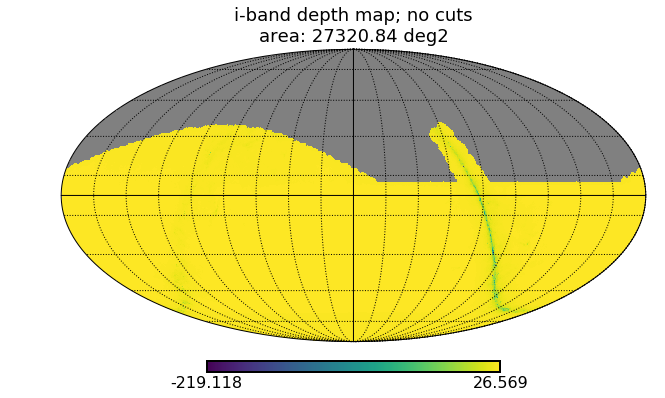

<Figure size 720x432 with 0 Axes>

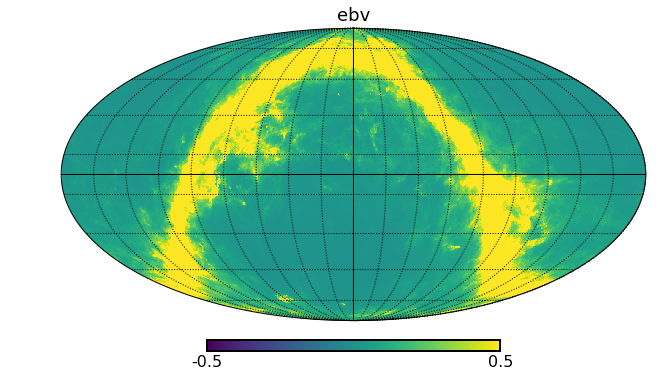

WFD total area: 21184.925633892017


<Figure size 720x432 with 0 Axes>

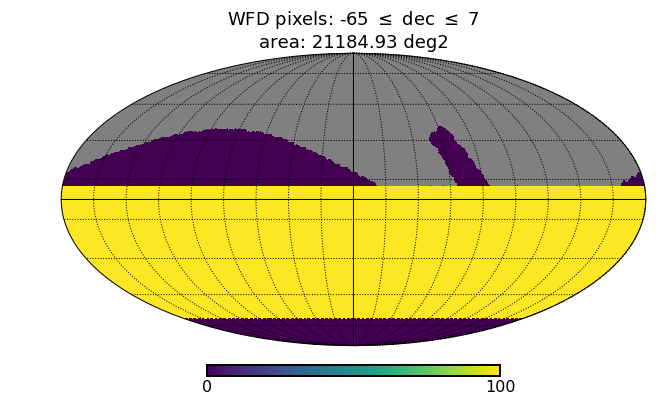

<Figure size 720x432 with 0 Axes>

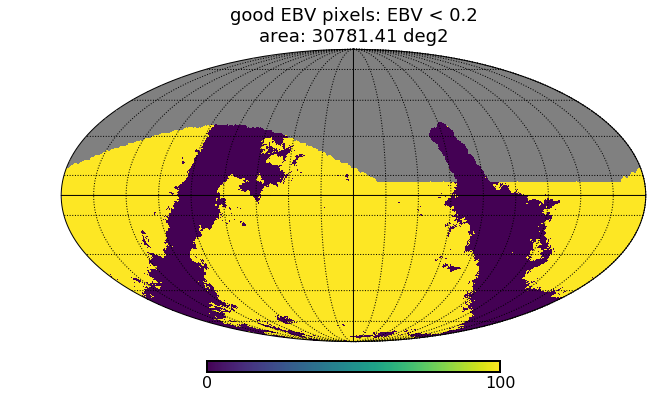

<Figure size 720x432 with 0 Axes>

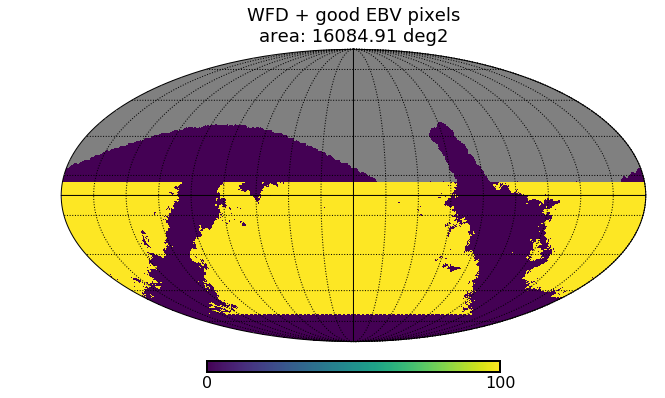

<Figure size 720x432 with 0 Axes>

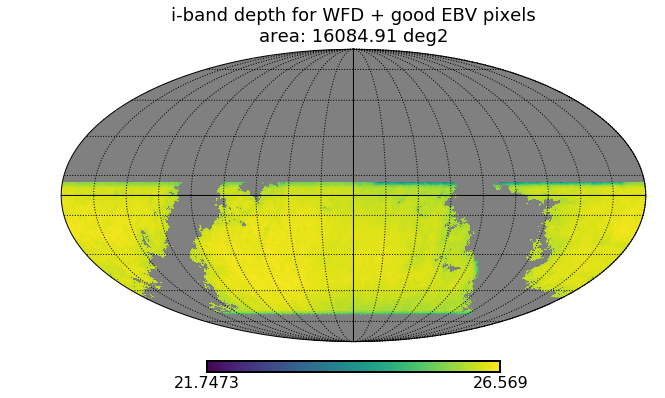

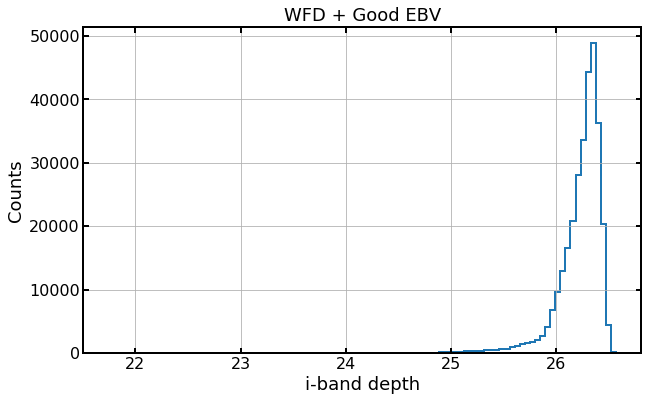

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


<Figure size 720x432 with 0 Axes>

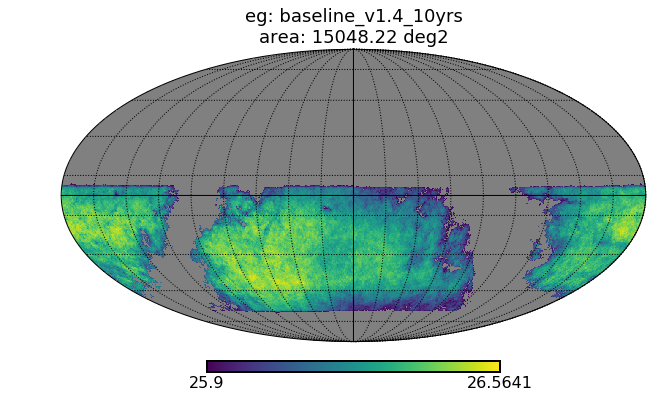

Total unmasked non-DD area: 27321 deg2 (520835 pixels) 
Total WFD + good-EBV area: 16085 deg2 (306637 pixels) 
Total good-EBV + good-depth area: 15048 deg2 (286874 pixels) 


<Figure size 720x432 with 0 Axes>

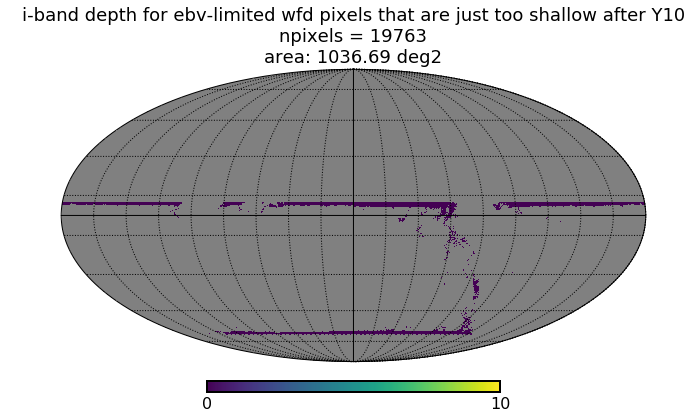

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['night', 'fieldRA', 'fieldDec']
Found 437227 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


<Figure size 720x432 with 0 Axes>

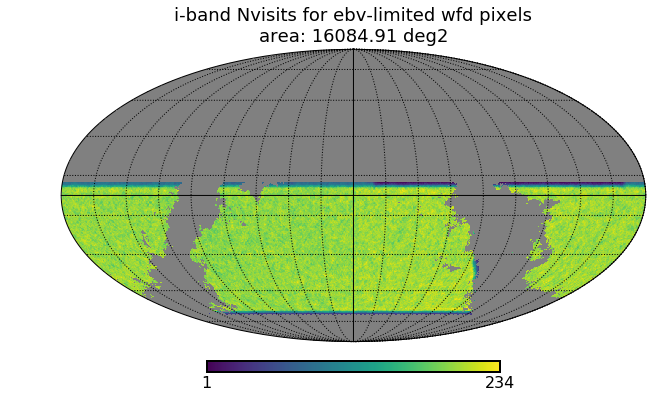

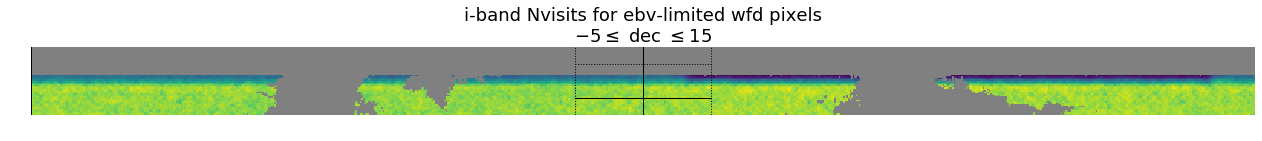

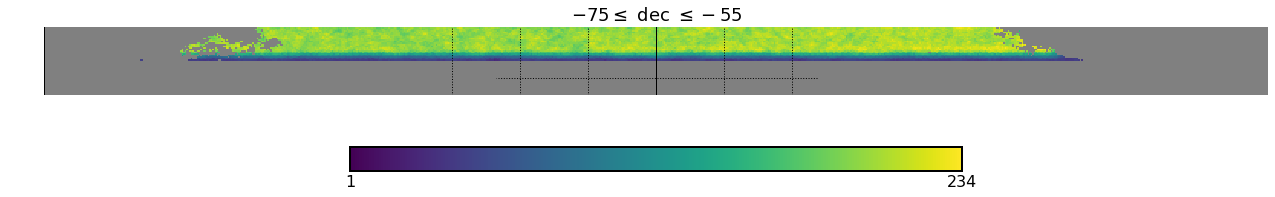

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" for columns ['night', 'fieldRA', 'fieldDec']
Found 1974950 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


<Figure size 720x432 with 0 Axes>

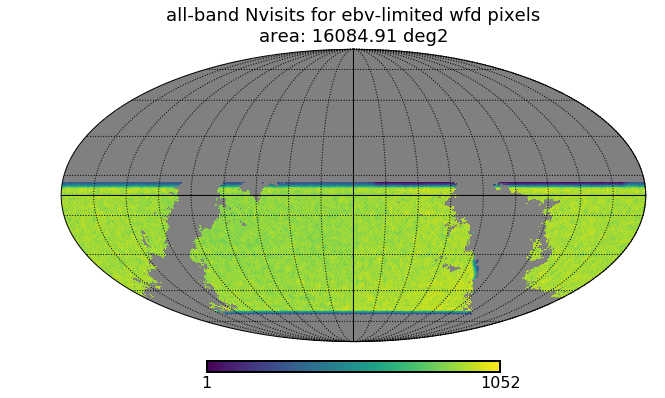

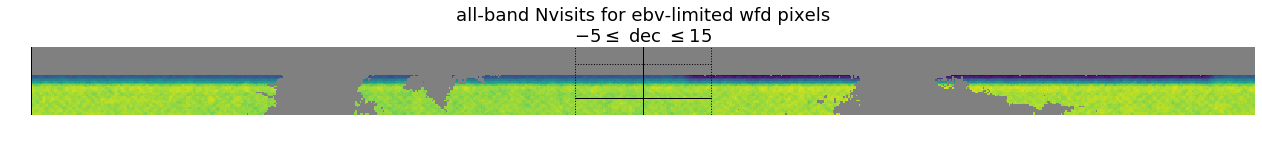

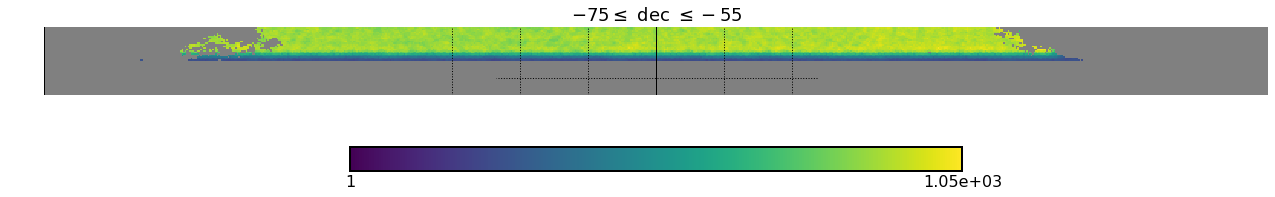

In [8]:
dbname = 'baseline_v1.4_10yrs'
dbpath = '%s/%s.db' % (dbdir, dbname)

fname = '/global/cscratch1/sd/awan/lsst_output/post_wp_output_v1.4_-0.1cuts/bundle_data/depth_in_eg_%s_i-band_limi25.9_nodither_nside256.npz' % dbname

out = run_things(dbpath=dbpath, fname=fname, nside=nside)

#### Okay it appears that we have some shallow edges that do not make past the depth cut for Y10.

#### Lets run things for the big-sky-with-dust footprint.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 432969 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


<Figure size 720x432 with 0 Axes>

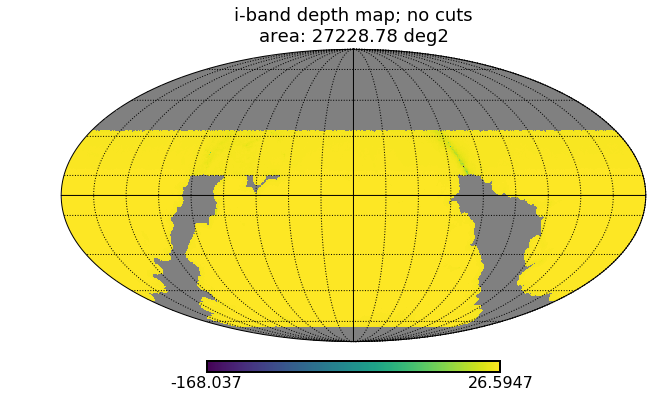

<Figure size 720x432 with 0 Axes>

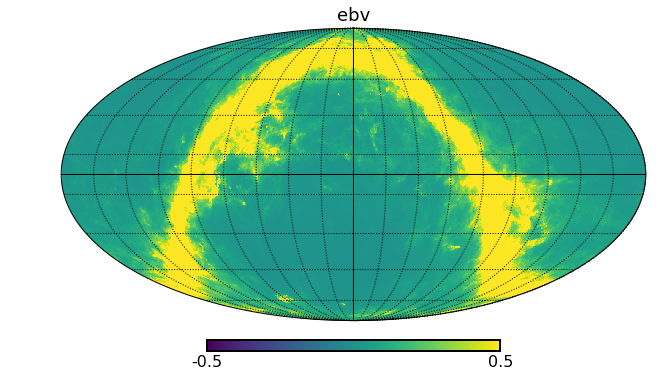

WFD total area: 20016.576423905244


<Figure size 720x432 with 0 Axes>

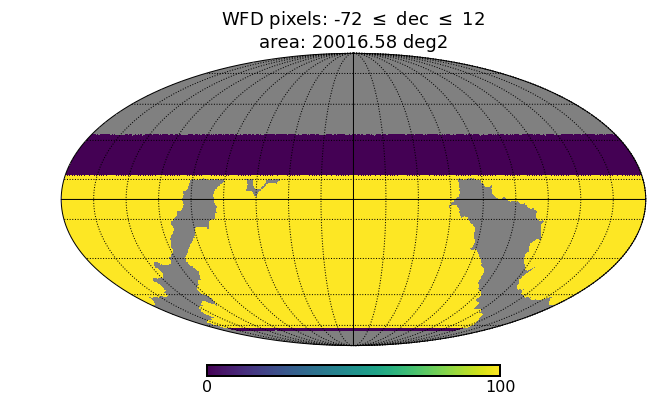

<Figure size 720x432 with 0 Axes>

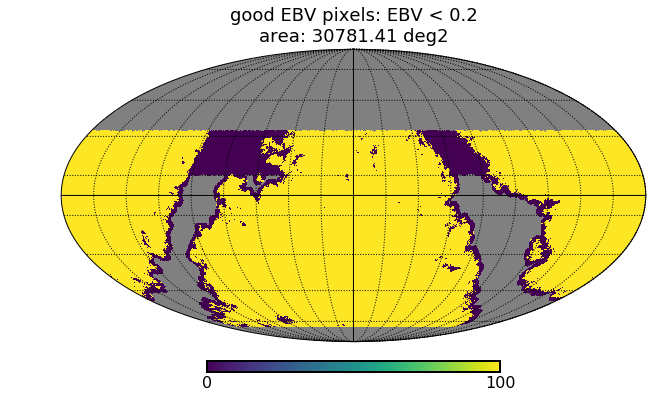

<Figure size 720x432 with 0 Axes>

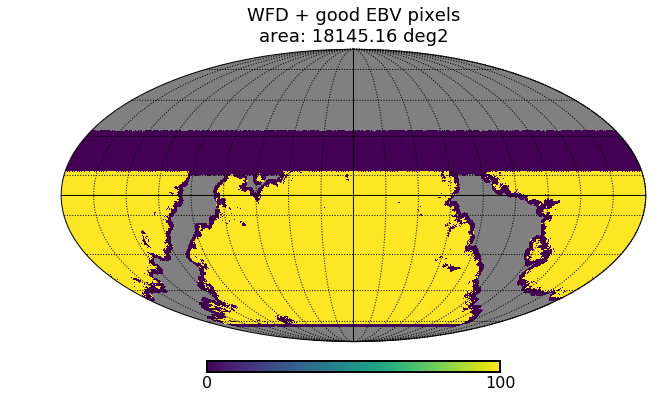

<Figure size 720x432 with 0 Axes>

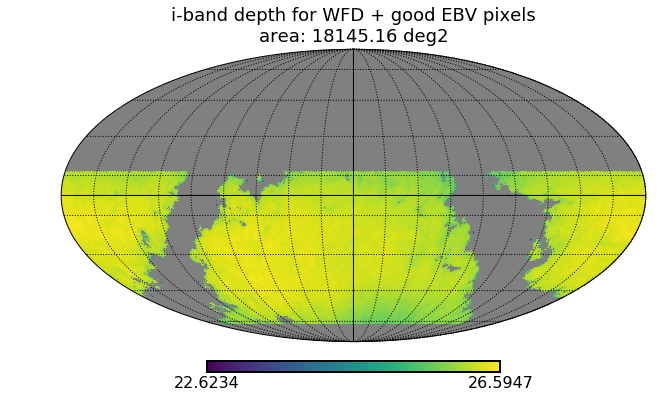

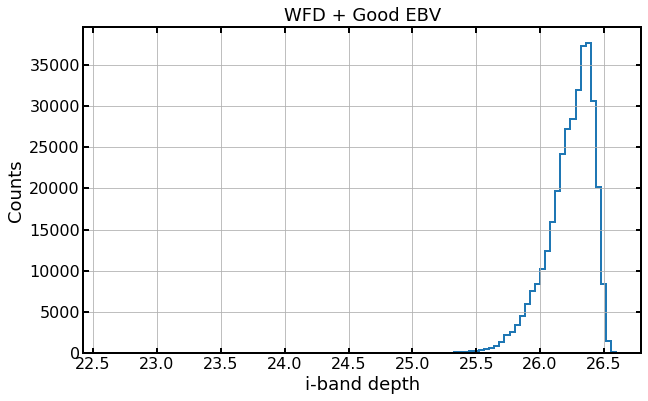

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


<Figure size 720x432 with 0 Axes>

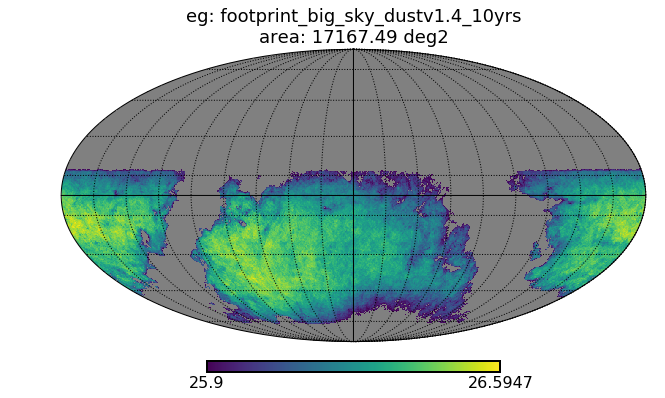

Total unmasked non-DD area: 27229 deg2 (519080 pixels) 
Total WFD + good-EBV area: 18145 deg2 (345913 pixels) 
Total good-EBV + good-depth area: 17167 deg2 (327275 pixels) 


<Figure size 720x432 with 0 Axes>

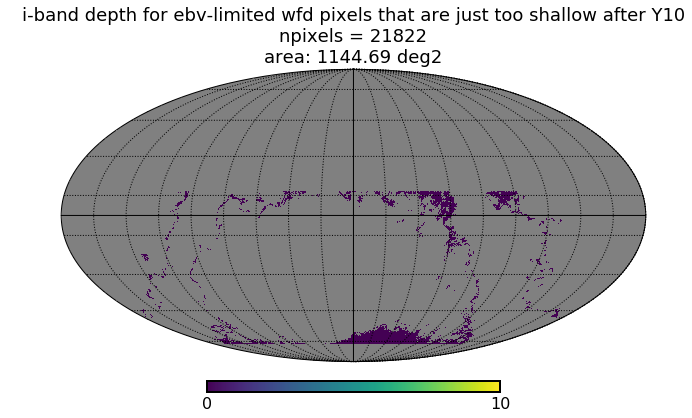

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['night', 'fieldRA', 'fieldDec']
Found 432969 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


<Figure size 720x432 with 0 Axes>

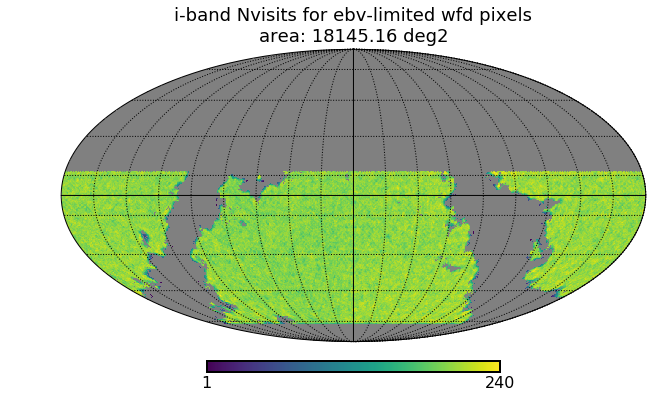

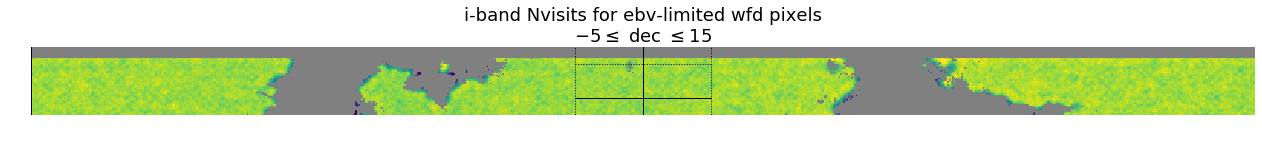

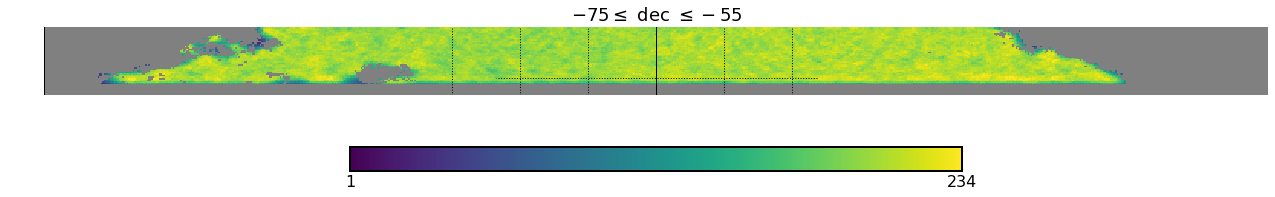

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" for columns ['night', 'fieldRA', 'fieldDec']
Found 1987038 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


<Figure size 720x432 with 0 Axes>

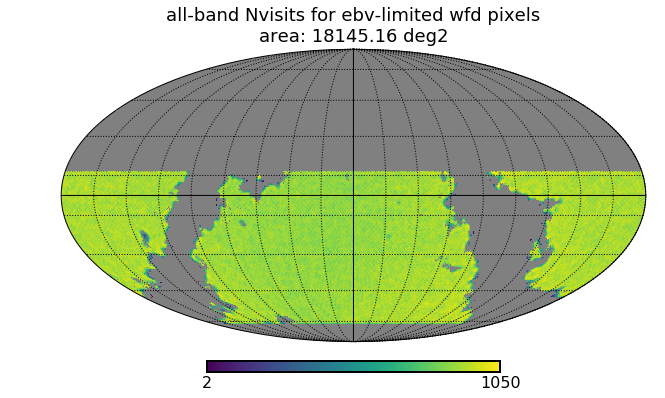

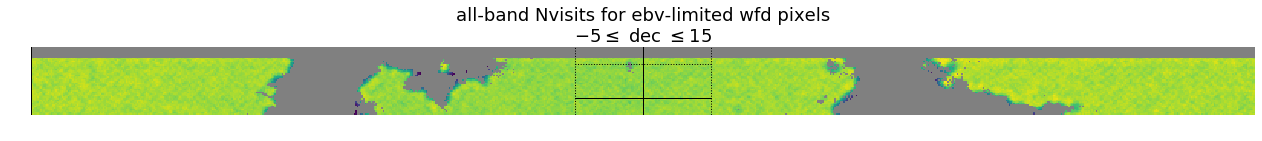

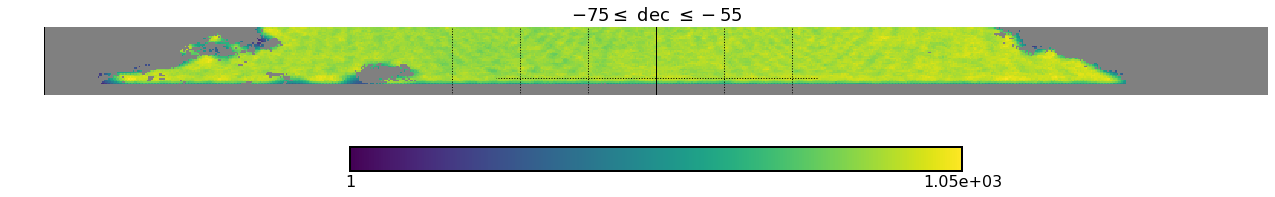

In [9]:
dbname = 'footprint_big_sky_dustv1.4_10yrs'
dbpath = '%s/%s.db' % (dbdir, dbname)

fname = '/global/cscratch1/sd/awan/lsst_output/post_wp_output_v1.4_-0.1cuts/bundle_data/depth_in_eg_%s_i-band_limi25.9_nodither_nside256.npz' % dbname

out = run_things(dbpath=dbpath, fname=fname, nside=nside, min_dec=-72, max_dec=12)

#### Interesting: we don't see the depth gradients at top/botton borders as we see in baseline (except close to the anti/galacti place) with the big-sky footprint.